In [92]:
import numpy as np
import random
import pickle as pkl
import os
from multiprocessing import Process, cpu_count
import codecs
from pprint import pprint
import sys
from collections import Counter
import matplotlib.pyplot as plt
from math import log

In [93]:
"""
Load training data
"""
training_file = codecs.open("data/ned.train", encoding="utf-8").readlines()
training_file = [l for l in training_file if "-DOCSTART-" not in l]

print "line count: ", len(training_file)

line count:  218450


In [94]:
"""
Look into the various features
"""

# Check how many features there are per word 
num_features = 0
for line in training_file:
    num_features = max(num_features, len(line.split()) - 2) # find the maximum amount of features

    
# Check the different possibilities for each feature
features = [{} for i in range(num_features)] # create a dictionary for each feature
for line in training_file:
    
    if line in ['\n', '\r\n']:
        
        continue
    else:
        words = line.split()[1:-1] # discard the word on the left and the final tag since this is the target

        for index, word in enumerate(words):
            if word not in features[index]:
                features[index][word] = True
                
print(num_features)
pprint([f.keys() for f in features])


1
[[u'Adv',
  u'Art',
  u'Int',
  u'Misc',
  u'N',
  u'Pron',
  u'Num',
  u'V',
  u'Punc',
  u'Conj',
  u'Adj',
  u'Prep']]


I-LOC:       0.23%
B-ORG:       1.03%
O:      90.48%
B-PER:       2.33%
I-PER:       1.42%
I-MISC:       0.69%
B-MISC:       1.65%
I-ORG:       0.59%
B-LOC:       1.58%


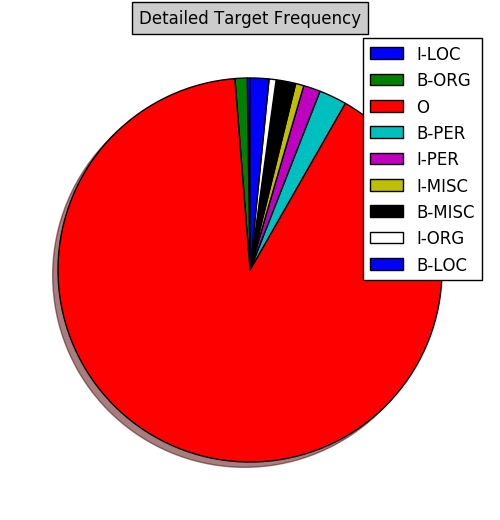

In [95]:
# Make a histogram of the occurance of each feature


inversed_matrix = []
for i in range(num_features + 2):
    inversed_matrix.append([])
    
for line in training_file:
    words = line.split()
    for index, word in enumerate(words):
        inversed_matrix[index].append(word)

        
word_freq = dict(Counter(inversed_matrix[0])).values()
target_freq = dict(Counter(inversed_matrix[-1]))

target_sum = np.array(target_freq.values()).sum()

"""
Print the distribution % wise
"""
for index, freq in target_freq.items():
    print("{}: {:10.2f}%".format(index, float(freq) / float(target_sum) * 100.0))

"""
Show the distribution in a pie chart
"""
# make a square figure and axes
plt.figure(1, figsize=(6,6))
ax = plt.axes([0.2, 0.2, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = target_freq.keys()
fracs = [float(f) / float(target_sum) * 100.0 for f in target_freq.values()]
patches, texts = plt.pie(fracs, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")

plt.title('Detailed Target Frequency', bbox={'facecolor':'0.8', 'pad':5})
plt.show()




ORG:       1.62%
MISC:       2.34%
O:      90.48%
PER:       3.75%
LOC:       1.81%


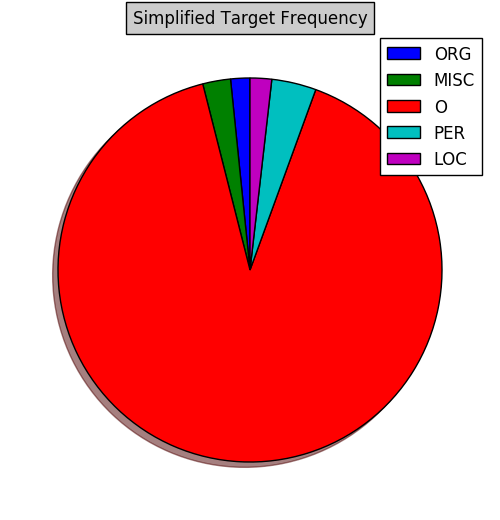

In [96]:
"""
Caluculate simplified target statistics
"""
target_freq = dict(Counter([f.replace("B-", "").replace("I-", "") for f in inversed_matrix[-1]]))

target_sum = np.array(target_freq.values()).sum()

"""
Print the distribution % wise
"""
for index, freq in target_freq.items():
    print("{}: {:10.2f}%".format(index, float(freq) / float(target_sum) * 100.0))

"""
Show the distribution in a pie chart
"""
# make a square figure and axes
plt.figure(1, figsize=(6,6))
ax = plt.axes([0.2, 0.2, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = target_freq.keys()
fracs = [float(f) / float(target_sum) * 100.0 for f in target_freq.values()]
patches, texts = plt.pie(fracs, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")

plt.title('Simplified Target Frequency', bbox={'facecolor':'0.8', 'pad':5})
plt.show()


sentence amount: 15806
Sentence distribution
{1: 2651,
 2: 1025,
 3: 392,
 4: 459,
 5: 892,
 6: 426,
 7: 520,
 8: 673,
 9: 540,
 10: 470,
 11: 530,
 12: 481,
 13: 483,
 14: 512,
 15: 445,
 16: 473,
 17: 381,
 18: 393,
 19: 351,
 20: 339,
 21: 319,
 22: 276,
 23: 286,
 24: 250,
 25: 247,
 26: 179,
 27: 195,
 28: 158,
 29: 151,
 30: 141,
 31: 135,
 32: 119,
 33: 110,
 34: 94,
 35: 84,
 36: 61,
 37: 64,
 38: 41,
 39: 58,
 40: 45,
 41: 35,
 42: 35,
 43: 21,
 44: 23,
 45: 28,
 46: 19,
 47: 21,
 48: 26,
 49: 19,
 50: 15,
 51: 7,
 52: 7,
 53: 6,
 54: 7,
 55: 10,
 56: 6,
 57: 9,
 58: 3,
 59: 6,
 60: 3,
 61: 4,
 62: 3,
 63: 5,
 65: 4,
 66: 3,
 67: 3,
 68: 4,
 69: 4,
 70: 2,
 71: 4,
 74: 1,
 79: 1,
 83: 1,
 89: 1,
 94: 1,
 101: 1,
 103: 1,
 108: 1,
 140: 1,
 148: 1,
 156: 1,
 454: 1,
 654: 1,
 708: 1,
 859: 1}


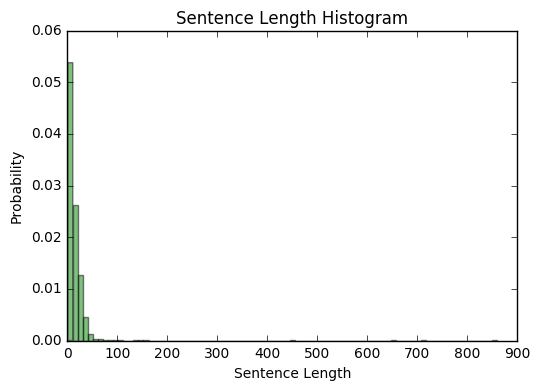

In [97]:
"""
Look into lenght of the sentences
"""
sentence_amount = training_file.count('\n')
print("sentence amount: {}".format(sentence_amount))

sentence_lengths = []
current_length = 0
current_sentence = []
for line in training_file:
    if line in ["\n", "\r\n", "\t\n", " \n", ""]:
        sentence_lengths.append(current_length)
        current_length = 0
        current_sentence = []
    else:
        current_length += 1
        current_sentence.append(line.split()[0])


sentence_counts = dict(Counter(sentence_lengths))

print("Sentence distribution")
pprint(sentence_counts)

"""
Plot the histogram
"""
num_bins = len(sentence_counts.values())
# the histogram of the data
n, bins, patches = plt.hist(x=sentence_counts.keys(), 
                            weights=sentence_counts.values(), bins=num_bins, normed=1, facecolor='green', alpha=0.5)

# add a 'best fit' line
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title(r'Sentence Length Histogram')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()


In [98]:
"""
Calculate best sentence cut
"""

cut_value = 30
print("Maximum Allowed Sentence Lenght: {}\n".format(cut_value))

below_cut = 0
above_cut = 0

for key, value in sentence_counts.items():
    if key <= cut_value:
        below_cut += value
    else:
        above_cut += value
        
total = below_cut + above_cut

print("Sentences that are not touched:")
print("Full amount: {}".format(below_cut))
print("Percentage: {:10.2f}%".format(float(below_cut) / total * 100))

print("\nSentences that are touched:")
print("Full amount: {}".format(above_cut))
print("Percentage: {:10.2f}%".format(float(above_cut) / total * 100))

Maximum Allowed Sentence Lenght: 30

Sentences that are not touched:
Full amount: 14638
Percentage:      92.61%

Sentences that are touched:
Full amount: 1168
Percentage:       7.39%
